In [1]:
import pyro
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
import pyro.distributions as dist
from sklearn.cluster import KMeans
from pyro.distributions import constraints
from ffjord.lib.toy_data import inf_train_gen
from pyro.nn import PyroModule, PyroParam, PyroSample
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
pyro.enable_validation(True)

In [2]:
class GaussianMixtureModel(PyroModule):
    def __init__(self, K):
        super().__init__()
        self.K = K
        self.M = None
        self.locs = None
        self.scales = None
        self.initialized = False
        self.fitted = False
        self.weights = PyroParam(torch.ones(K) / K,
                                 constraint=constraints.simplex)
        self.losses = list()
        self.eval()
    
    
    def random_init(self, M):
        self.M = M
        self.locs = PyroParam(torch.rand(self.K, self.M),
                              constraint=constraints.real)
        self.scales = PyroParam(torch.rand(self.K, self.M),
                                constraint=constraints.positive)
        self.initialized = True
    
    
    def constant_init(self, M, loc=0., scale=1.):
        self.M = M
        self.locs = PyroParam(torch.ones(self.K, self.M)*loc,
                             constraint=constraints.real)
        self.scales = PyroParam(torch.ones(self.K, self.M)*scale,
                             constraint=constraints.real)
        self.initialized = True
    
    
    def init_from_data(self, data, k_means=False):
        N, M = data.shape[0], data.shape[1]
        self.M = M
        self.locs = PyroParam(data[torch.multinomial(torch.ones(N) / N, self.K),],
                              constraint=constraints.real)
        self.scales = PyroParam(data.std(dim=0).repeat(self.K).reshape(self.K, self.M),
                                constraint=constraints.positive)
        
        if k_means:
            data = data.numpy()
            k_means_model = KMeans(self.K)
            k_means_model.fit(data)
            locs = k_means_model.cluster_centers_
            self.locs = PyroParam(torch.tensor(locs),
                              constraint=constraints.real)
            
        self.initialized = True
    
    
    @config_enumerate
    def forward(self, data=None):
        shape = data.shape if data is not None else (1000, 2)
        N, M = shape[0], shape[1]
        
        if self.initialized is False and data is not None:
            self.init_from_data(data)
            self.initialized = True
        elif self.initialized is False:
            self.random_init(M)
            self.initalized = True
        
        if M != self.M:
            raise ValueError('Incorrect number of data columns.')
        
        x_obs = torch.zeros(N, M)
        with pyro.plate('data', N):
            k = pyro.sample('k', dist.Categorical(self.weights))
            
            for m in range(self.M):
                obs = data[:,m] if data is not None else None
                x_obs[:,m] = pyro.sample('x_{}'.format(m),
                                         dist.Normal(loc=self.locs[k, m],
                                                     scale=self.scales[k, m]),
                                        obs=obs)
            return x_obs
        
    
    def guide(self, data):
        pass
    
    
    def fit_model(self, data, lr=3e-4, n_steps=10000):
        self.train()
        
        N = len(data)
        adam = pyro.optim.Adam({"lr": lr})
        svi = SVI(self, self.guide, adam, loss=TraceEnum_ELBO())
        
        for step in range(n_steps):
            loss = svi.step(data)
            self.losses.append(loss / N)
            
            if step % 1000 == 0:
                nllh = -self.log_likelihood(data)
                print('[iter {}]  loss: {:.4f}'.format(step, loss))
        
        self.fitted = True
        self.eval()
    
    
    def density(self, data):
        with torch.no_grad():
            N, M = data.shape[0], data.shape[1]
            if M != self.M:
                raise ValueError('Incorrect number of data columns.')
            
            log_probs = dist.Normal(loc=self.locs,
                                    scale=self.scales).log_prob(
                                    data.unsqueeze(1))
            density = (
                torch.exp(log_probs.sum(dim=2))*self.weights).sum(dim=1)
            
            return density
        
    
    def log_likelihood(self, data):
        with torch.no_grad():
            llh = torch.log(self.density(data)).sum()
            return llh
    
    
    def eval_density_grid(self, n_points=100):
        if self.M != 2:
            raise ValueError('Can only evaluate density grid for 2-dimensional data.')
        x_range = np.linspace(-5, 5, n_points)
        X1, X2 = np.meshgrid(x_range, x_range)
        XX = np.column_stack((X1.ravel(), X2.ravel()))
        densities = self.density(torch.tensor(XX)).numpy()
        
        return x_range, densities.reshape((n_points, n_points))
        


In [3]:
def plot_train_loss(model):
    fig = plt.figure(figsize=(8,6))
    plt.plot(model.losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training loss')
    plt.show();


def plot_density(model, data):
    x_range, density_eval = model.eval_density_grid(n_points=500)
    fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2,
                                    figsize=(20, 10))
    # Plot of data and contour lines of density
    ax1.plot(data[:,0], data[:,1], 'b.', markersize=1)
    ax1.contour(x_range, x_range, density_eval, colors='red')
    ax1.set_xlabel('x_1')
    ax1.set_ylabel('x_2')
    ax1.set_title('Data and contour lines of density')

    # Color map of density
    cm = ax2.pcolormesh(x_range, x_range, density_eval, cmap=plt.cm.RdBu_r, shading='auto')
    cbar = fig.colorbar(cm)
    ax2.set_xlabel('x_1')
    ax2.set_ylabel('x_2')
    ax2.set_title('Heat map of density')
    plt.show();


# 8 Gaussians data

In [4]:
# Generate synthetic data
data = torch.tensor(inf_train_gen('8gaussians', batch_size=5000),
                    dtype=torch.float)

In [5]:
# Train model
pyro.clear_param_store()
model = GaussianMixtureModel(K=8)
model.init_from_data(data, k_means=True)
model.fit_model(data, n_steps=8000)

[iter 0]  loss: 22150.9941
[iter 1000]  loss: 20726.8164
[iter 2000]  loss: 19408.0234
[iter 3000]  loss: 18329.4336
[iter 4000]  loss: 16707.3750
[iter 5000]  loss: 14830.9141
[iter 6000]  loss: 14257.4453
[iter 7000]  loss: 14181.8164


In [6]:
# Log likelihood of data
print('Log likelihood of data:', model.log_likelihood(data).item())

Log likelihood of data: -14179.349609375


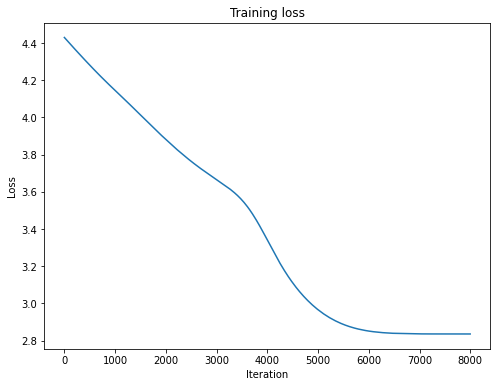

In [7]:
# Plot training loss
plot_train_loss(model)

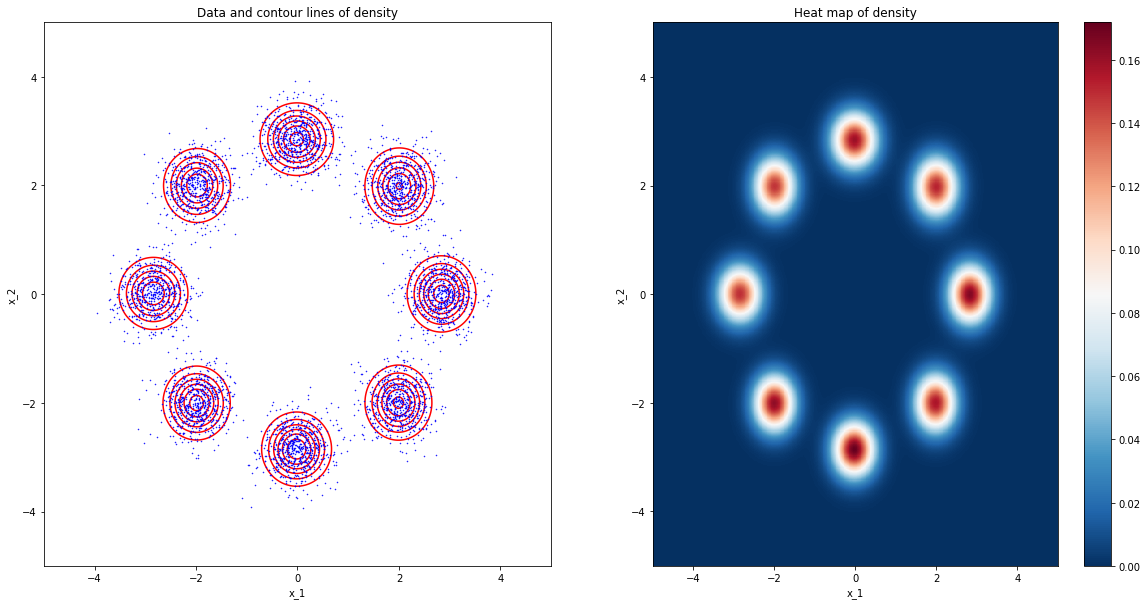

In [8]:
# Plot density
plot_density(model, data)

# Checkerboard data 

In [9]:
# Generate synthetic data
data = torch.tensor(inf_train_gen('checkerboard', batch_size=5000),
                    dtype=torch.float)

In [10]:
# Train model
pyro.clear_param_store()
model = GaussianMixtureModel(K=8)
model.init_from_data(data, k_means=True)
model.fit_model(data, n_steps=8000)

[iter 0]  loss: 23426.0410
[iter 1000]  loss: 22346.5449
[iter 2000]  loss: 21512.9551
[iter 3000]  loss: 20449.4082
[iter 4000]  loss: 19234.9434
[iter 5000]  loss: 18972.8359
[iter 6000]  loss: 18962.9023
[iter 7000]  loss: 18962.8262


In [11]:
# Log likelihood of data
print('Log likelihood of data:', model.log_likelihood(data).item())

Log likelihood of data: -18962.845703125


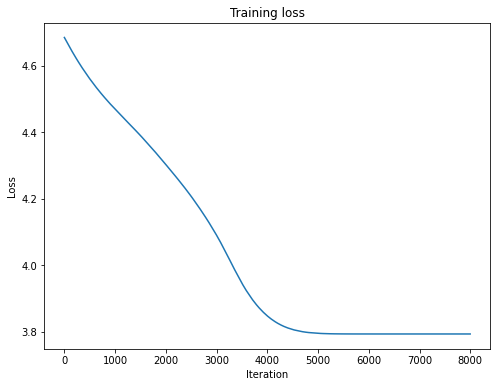

In [12]:
# Plot training loss
plot_train_loss(model)

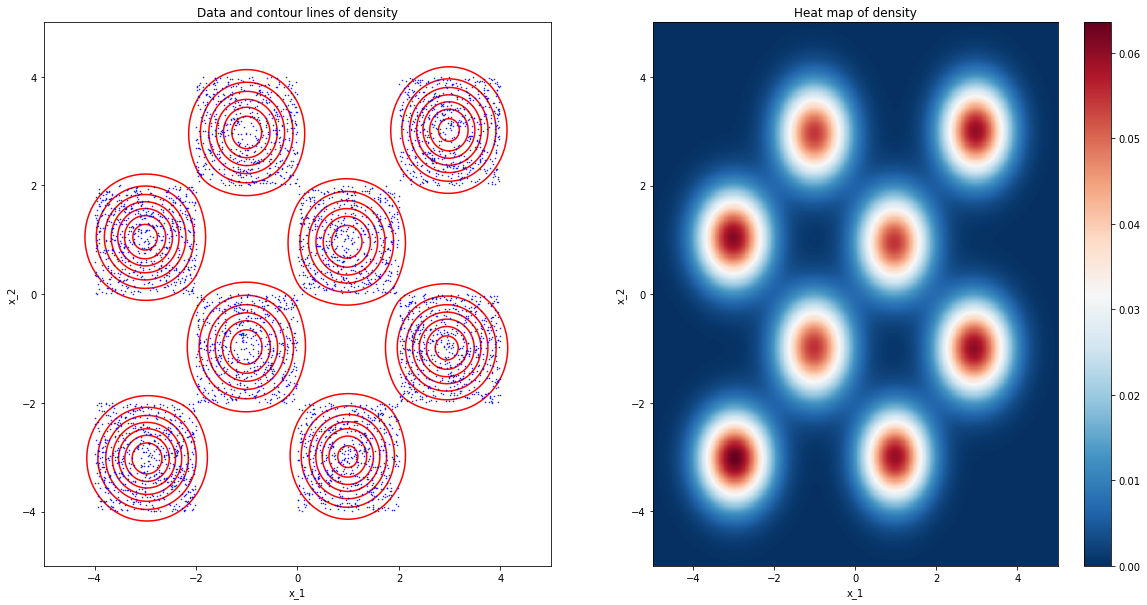

In [13]:
# Plot density
plot_density(model, data)

# 2 Spirals data

In [24]:
# Generate synthetic data
data = torch.tensor(inf_train_gen('2spirals', batch_size=5000),
                    dtype=torch.float)

In [25]:
# Train model
pyro.clear_param_store()
model = GaussianMixtureModel(K=8)
model.init_from_data(data, k_means=True)
model.fit_model(data, n_steps=8000)

[iter 0]  loss: 19741.9336
[iter 1000]  loss: 18605.3145
[iter 2000]  loss: 18153.1582
[iter 3000]  loss: 17955.6680
[iter 4000]  loss: 17746.2598
[iter 5000]  loss: 17463.3984
[iter 6000]  loss: 17170.4102
[iter 7000]  loss: 17111.4688


In [26]:
# Log likelihood of data
print('Log likelihood of data:', model.log_likelihood(data).item())

Log likelihood of data: -17095.98828125


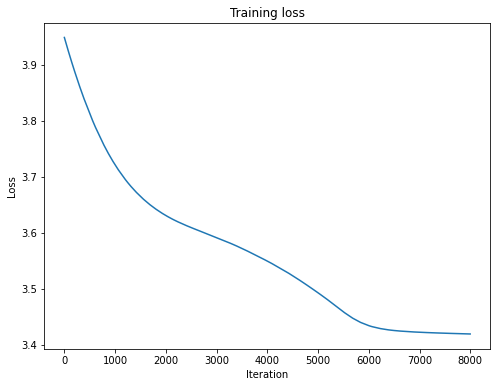

In [27]:
# Plot training loss
plot_train_loss(model)

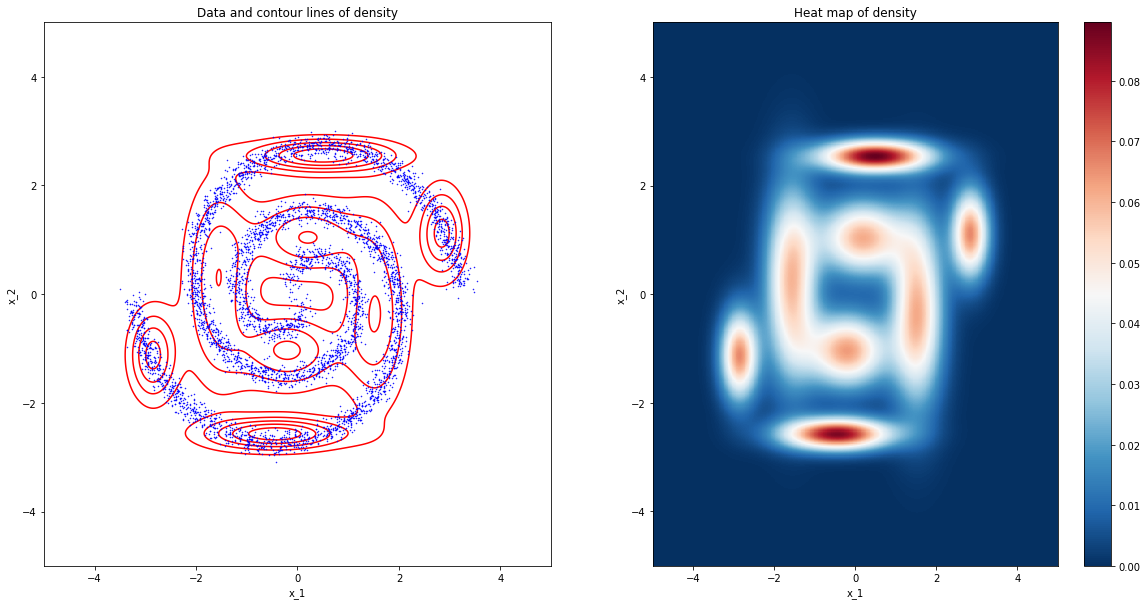

In [28]:
# Plot density
plot_density(model, data)